## 00.Pacotes.

In [ ]:
import pandas as pd
import numpy as np
import funcoes_basicas as funcs
import funcoes_derivadas as funcs_deriv
import random
import gc

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

from lightgbm import LGBMClassifier
import lightgbm as lgb

# Filter out the ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning

from datetime import date, datetime
from tqdm import tqdm
from scipy.stats import ks_2samp

import xgboost as xgb
import optuna
import pickle
import shap

from joblib import dump, load

def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y == 1], y_pred[y != 1]).statistic

ks_score = make_scorer(ks_stat)

# Definindo a semente
random.seed(123)

import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 01. Base do modelo xgb

In [ ]:
# Baixando a base final salva do xgb
df_xgb = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_final_modelo_xgboost.parquet',
                                 engine='pyarrow')
df_xgb.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,...,num__INCOME_TO_BIRTH_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,...,-19.10,-999.0,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,...,-4.60,0.0,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,...,-18.76,-999.0,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,...,-5.06,0.0,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,...,-5.50,-999.0,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0


In [ ]:
#Criando as faixas de score do xgb
df_xgb['faixas_score_xgb'] = pd.qcut(df_xgb['score'], 4, duplicates = 'drop')

In [ ]:
df_xgb.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,...,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito,faixas_score_xgb
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,...,-999.0,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0,"(970.0, 997.0]"
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,...,0.0,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0,"(902.0, 947.0]"
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,...,-999.0,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0,"(902.0, 947.0]"
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,...,0.0,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0,"(970.0, 997.0]"
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,...,-999.0,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0,"(947.0, 970.0]"


In [ ]:
df_xgb['faixas_score_xgb'].value_counts().sort_index()

faixas_score_xgb
(198.999, 902.0]    46463
(902.0, 947.0]      46569
(947.0, 970.0]      47544
(970.0, 997.0]      43774
Name: count, dtype: int64

In [ ]:
df_xgb.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184350 entries, 0 to 184349
Data columns (total 39 columns):
 #   Column                                                              Non-Null Count   Dtype   
---  ------                                                              --------------   -----   
 0   SK_ID_CURR                                                          184350 non-null  int32   
 1   TARGET                                                              184350 non-null  int32   
 2   num__EXT_SOURCE_3_publico                                           184350 non-null  float32 
 3   num__EXT_SOURCE_2_publico                                           184350 non-null  float32 
 4   num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo  184350 non-null  float32 
 5   num__CREDIT_TO_GOODS_RATIO_publico                                  184350 non-null  float32 
 6   num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo  184350 non-null  float32

faixas_score_xgb
(198.999, 902.0]    46463
(902.0, 947.0]      46569
(947.0, 970.0]      47544
(970.0, 997.0]      43774

In [ ]:
def atribuir_rating_xgb(df, coluna_faixa='faixas_score_xgb', nova_coluna='rating_xgb'):
    # Define o mapeamento fixo conforme a ordem das faixas
    mapa_rating = {
        pd.Interval(198.999,902.0, closed='right'): 1,
        pd.Interval(902.0, 947.0, closed='right'): 2,
        pd.Interval(947.0, 970.0, closed='right'): 3,
        pd.Interval(970.0, 997.0, closed='right'): 4
    }
    df[nova_coluna] = df[coluna_faixa].replace(mapa_rating)
    return df

df_xgb = atribuir_rating_xgb(df_xgb)

In [ ]:
df_xgb.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,...,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito,faixas_score_xgb,rating_xgb
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,...,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0,"(970.0, 997.0]",4
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,...,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0,"(902.0, 947.0]",2
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,...,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0,"(902.0, 947.0]",2
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,...,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0,"(970.0, 997.0]",4
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,...,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0,"(947.0, 970.0]",3


In [ ]:
df_xgb['rating_xgb'].value_counts().sort_index()

rating_xgb
1    46463
2    46569
3    47544
4    43774
Name: count, dtype: int64

## 02. Base do lgbm

In [ ]:
# Baixando a base salva do modelo lightgbm
df_lgbm = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_final_modelo_lgbm.parquet',
                                 engine='pyarrow')
df_lgbm.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__AMT_GOODS_PRICE_publico,num__PAYMENT_RATE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo,num__EXT_SOURCE_1_publico,num__CREDIT_TO_GOODS_RATIO_publico,...,num__REGION_RATING_CLIENT_W_CITY_publico,cat__NAME_EDUCATION_TYPE_publico_Higher_education,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,num__DAYS_REGISTRATION_publico,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,periodo,score,prob0,prob1,predito
0,100010,0,0.540654,0.714279,1530000.0,0.03,-999.0,-999.0,-999.000000,1.00,...,3.0,1.0,-999.0,-4597.0,0.0,treino,744,0.743790,0.256210,0
1,100263,0,0.270707,0.235314,585000.0,0.06,133240.5,405.0,0.770814,1.00,...,2.0,1.0,-21.0,-2267.0,0.0,treino,644,0.644217,0.355783,0
2,100320,0,-999.000000,0.610447,463500.0,0.10,-999.0,10489.0,-999.000000,1.04,...,2.0,0.0,-999.0,-2562.0,0.0,treino,675,0.674585,0.325415,0
3,100704,0,0.621226,0.398296,760500.0,0.03,29682.0,1344.0,0.676170,1.00,...,2.0,1.0,-49.0,-6650.0,1.0,treino,822,0.822484,0.177516,0
4,100768,0,0.556727,0.639849,229500.0,0.04,-999.0,230.0,0.722559,1.21,...,2.0,0.0,-999.0,-10241.0,1.0,treino,846,0.845637,0.154363,0


In [ ]:
#Criando as faixas de score
df_lgbm['faixas_score_lgbm'] = pd.qcut(df_lgbm['score'], 4, duplicates = 'drop')

In [ ]:
df_lgbm.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__AMT_GOODS_PRICE_publico,num__PAYMENT_RATE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo,num__EXT_SOURCE_1_publico,num__CREDIT_TO_GOODS_RATIO_publico,...,cat__NAME_EDUCATION_TYPE_publico_Higher_education,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,num__DAYS_REGISTRATION_publico,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,periodo,score,prob0,prob1,predito,faixas_score_lgbm
0,100010,0,0.540654,0.714279,1530000.0,0.03,-999.0,-999.0,-999.000000,1.00,...,1.0,-999.0,-4597.0,0.0,treino,744,0.743790,0.256210,0,"(649.0, 771.0]"
1,100263,0,0.270707,0.235314,585000.0,0.06,133240.5,405.0,0.770814,1.00,...,1.0,-21.0,-2267.0,0.0,treino,644,0.644217,0.355783,0,"(479.0, 649.0]"
2,100320,0,-999.000000,0.610447,463500.0,0.10,-999.0,10489.0,-999.000000,1.04,...,0.0,-999.0,-2562.0,0.0,treino,675,0.674585,0.325415,0,"(649.0, 771.0]"
3,100704,0,0.621226,0.398296,760500.0,0.03,29682.0,1344.0,0.676170,1.00,...,1.0,-49.0,-6650.0,1.0,treino,822,0.822484,0.177516,0,"(771.0, 980.0]"
4,100768,0,0.556727,0.639849,229500.0,0.04,-999.0,230.0,0.722559,1.21,...,0.0,-999.0,-10241.0,1.0,treino,846,0.845637,0.154363,0,"(771.0, 980.0]"


In [ ]:
df_lgbm['faixas_score_lgbm'].value_counts().sort_index()

faixas_score_lgbm
(29.999, 479.0]    46135
(479.0, 649.0]     46110
(649.0, 771.0]     46288
(771.0, 980.0]     45817
Name: count, dtype: int64

In [ ]:
df_lgbm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184350 entries, 0 to 184349
Data columns (total 34 columns):
 #   Column                                                            Non-Null Count   Dtype   
---  ------                                                            --------------   -----   
 0   SK_ID_CURR                                                        184350 non-null  int32   
 1   TARGET                                                            184350 non-null  int32   
 2   num__EXT_SOURCE_3_publico                                         184350 non-null  float32 
 3   num__EXT_SOURCE_2_publico                                         184350 non-null  float32 
 4   num__AMT_GOODS_PRICE_publico                                      184350 non-null  float32 
 5   num__PAYMENT_RATE_publico                                         184350 non-null  float32 
 6   num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo   184350 non-null  float32 
 7   num__QT_MAX

In [ ]:
def atribuir_rating_lgbm(df, coluna_faixa='faixas_score_lgbm', nova_coluna='rating_lgbm'):
    # Define o mapeamento fixo conforme a ordem das faixas
    mapa_rating = {
        pd.Interval(29.999, 479.0, closed='right'): 1,
        pd.Interval(479.0, 649.0, closed='right'): 2,
        pd.Interval(649.0, 771.0, closed='right'): 3,
        pd.Interval(771.0, 980.0, closed='right'): 4
    }
    df[nova_coluna] = df[coluna_faixa].replace(mapa_rating)
    return df

df_lgbm = atribuir_rating_lgbm(df_lgbm)

In [ ]:
df_lgbm.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__AMT_GOODS_PRICE_publico,num__PAYMENT_RATE_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo,num__EXT_SOURCE_1_publico,num__CREDIT_TO_GOODS_RATIO_publico,...,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,num__DAYS_REGISTRATION_publico,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,periodo,score,prob0,prob1,predito,faixas_score_lgbm,rating_lgbm
0,100010,0,0.540654,0.714279,1530000.0,0.03,-999.0,-999.0,-999.000000,1.00,...,-999.0,-4597.0,0.0,treino,744,0.743790,0.256210,0,"(649.0, 771.0]",3
1,100263,0,0.270707,0.235314,585000.0,0.06,133240.5,405.0,0.770814,1.00,...,-21.0,-2267.0,0.0,treino,644,0.644217,0.355783,0,"(479.0, 649.0]",2
2,100320,0,-999.000000,0.610447,463500.0,0.10,-999.0,10489.0,-999.000000,1.04,...,-999.0,-2562.0,0.0,treino,675,0.674585,0.325415,0,"(649.0, 771.0]",3
3,100704,0,0.621226,0.398296,760500.0,0.03,29682.0,1344.0,0.676170,1.00,...,-49.0,-6650.0,1.0,treino,822,0.822484,0.177516,0,"(771.0, 980.0]",4
4,100768,0,0.556727,0.639849,229500.0,0.04,-999.0,230.0,0.722559,1.21,...,-999.0,-10241.0,1.0,treino,846,0.845637,0.154363,0,"(771.0, 980.0]",4


In [ ]:
df_lgbm['rating_lgbm'].value_counts().sort_index()

rating_lgbm
1    46135
2    46110
3    46288
4    45817
Name: count, dtype: int64

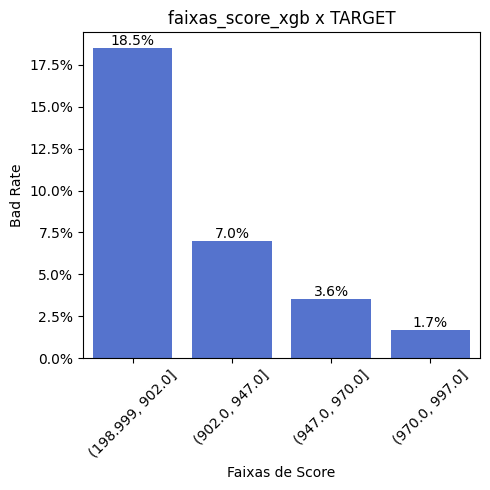

In [ ]:
funcs_deriv.grafico_score_vs_target(df_xgb, 'faixas_score_xgb', 'TARGET')

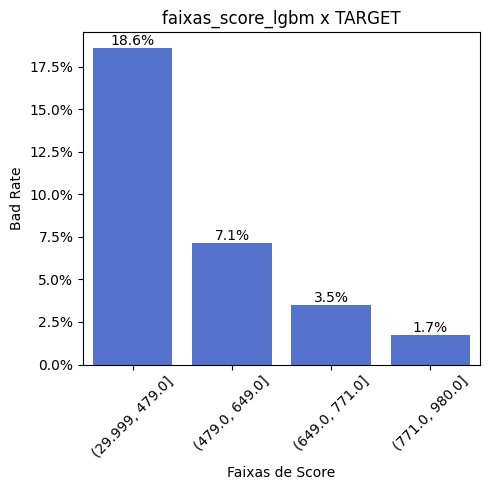

In [ ]:
funcs_deriv.grafico_score_vs_target(df_lgbm, 'faixas_score_lgbm', 'TARGET')

## Matrizes de Migração de Volumetria e Inadimplência: xgb x lgbm

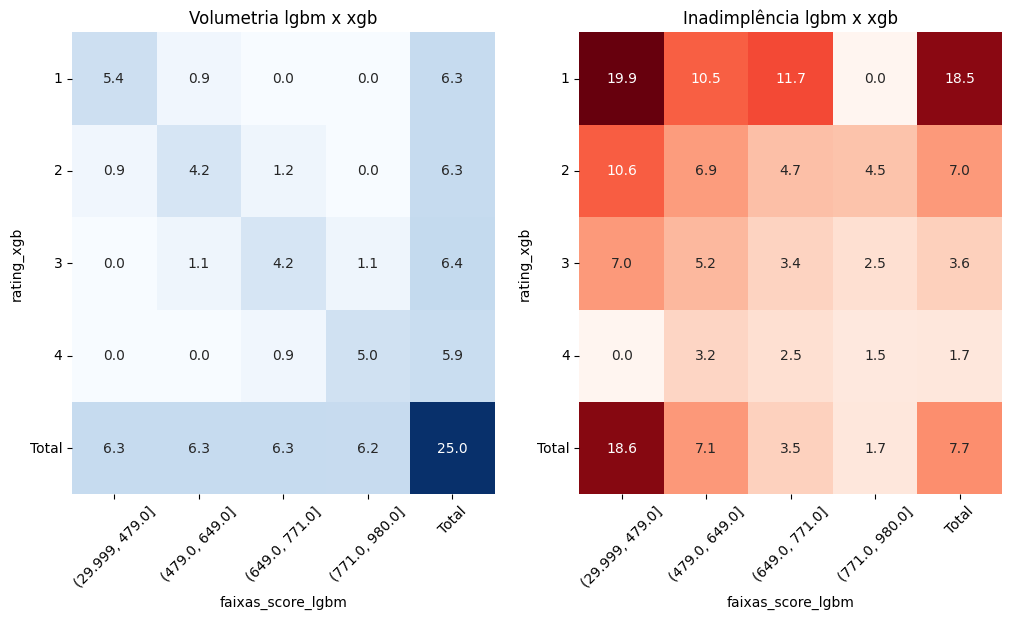

In [ ]:
# Matrizes de Migração de Volumetria e Inadimplência: xgb x lgbm

funcs_deriv.plot_matrizes_lado_a_lado(
    df1=df_xgb,
    df2=df_lgbm,
    id_col='SK_ID_CURR',
    col_rating='rating_xgb',
    col_score='faixas_score_lgbm',
    col_target='TARGET',
    titulo_vol='Volumetria lgbm x xgb',
    titulo_inad='Inadimplência lgbm x xgb'
)

## Matrizes de Migração de Volumetria e Inadimplência: lgbm x xgb

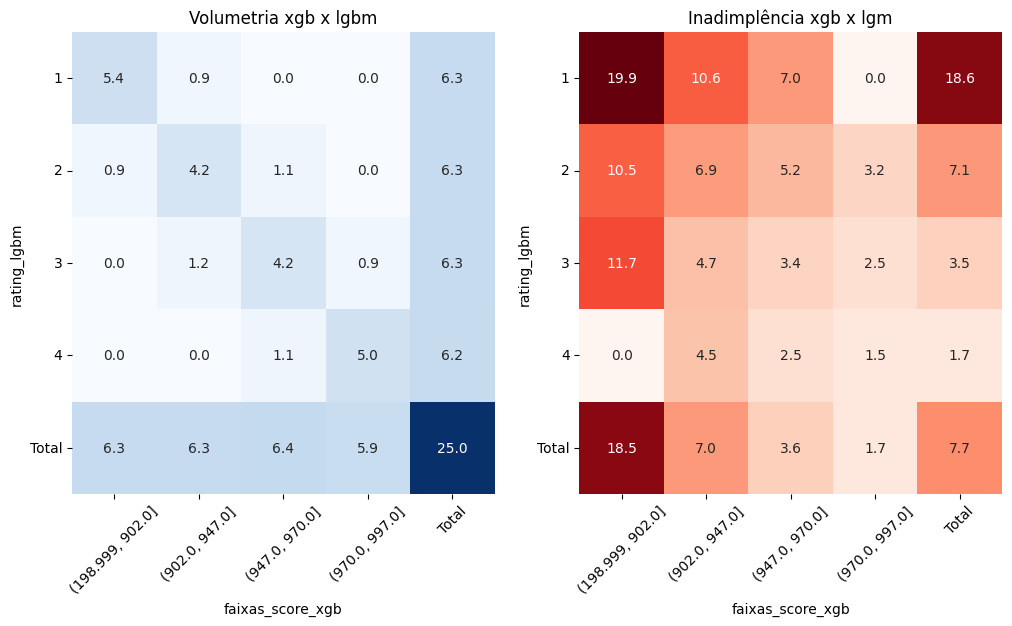

In [ ]:
# Matrizes de Migração de Volumetria e Inadimplência: lgbm x xgb

funcs_deriv.plot_matrizes_lado_a_lado(
    df1=df_lgbm,
    df2=df_xgb,
    id_col='SK_ID_CURR',
    col_rating='rating_lgbm',
    col_score='faixas_score_xgb',
    col_target='TARGET',
    titulo_vol='Volumetria xgb x lgbm',
    titulo_inad='Inadimplência xgb x lgm'
)